(QuantumRegister(16, 'q'), 0) []
(QuantumRegister(16, 'q'), 1) []
(QuantumRegister(16, 'q'), 2) [(1, (QuantumRegister(6, 'q'), 0), (ClassicalRegister(3, 'measure_q'), 0)), (0, (QuantumRegister(3, 'ancilla_q'), 0))]
(QuantumRegister(16, 'q'), 3) []
(QuantumRegister(16, 'q'), 4) []
(QuantumRegister(16, 'q'), 5) []
(QuantumRegister(16, 'q'), 6) []
(QuantumRegister(16, 'q'), 7) [(0, (QuantumRegister(10, 'q'), 5), (ClassicalRegister(1, 'measure_q'), 0)), (1, (QuantumRegister(1, 'ancilla_q'), 0))]
(QuantumRegister(16, 'q'), 8) []
(QuantumRegister(16, 'q'), 9) []
(QuantumRegister(16, 'q'), 10) [(1, (QuantumRegister(6, 'q'), 2), (ClassicalRegister(3, 'measure_q'), 1)), (0, (QuantumRegister(3, 'ancilla_q'), 1))]
(QuantumRegister(16, 'q'), 11) []
(QuantumRegister(16, 'q'), 12) []
(QuantumRegister(16, 'q'), 13) []
(QuantumRegister(16, 'q'), 14) [(1, (QuantumRegister(6, 'q'), 4), (ClassicalRegister(3, 'measure_q'), 2)), (0, (QuantumRegister(3, 'ancilla_q'), 2))]
(QuantumRegister(16, 'q'), 15) []


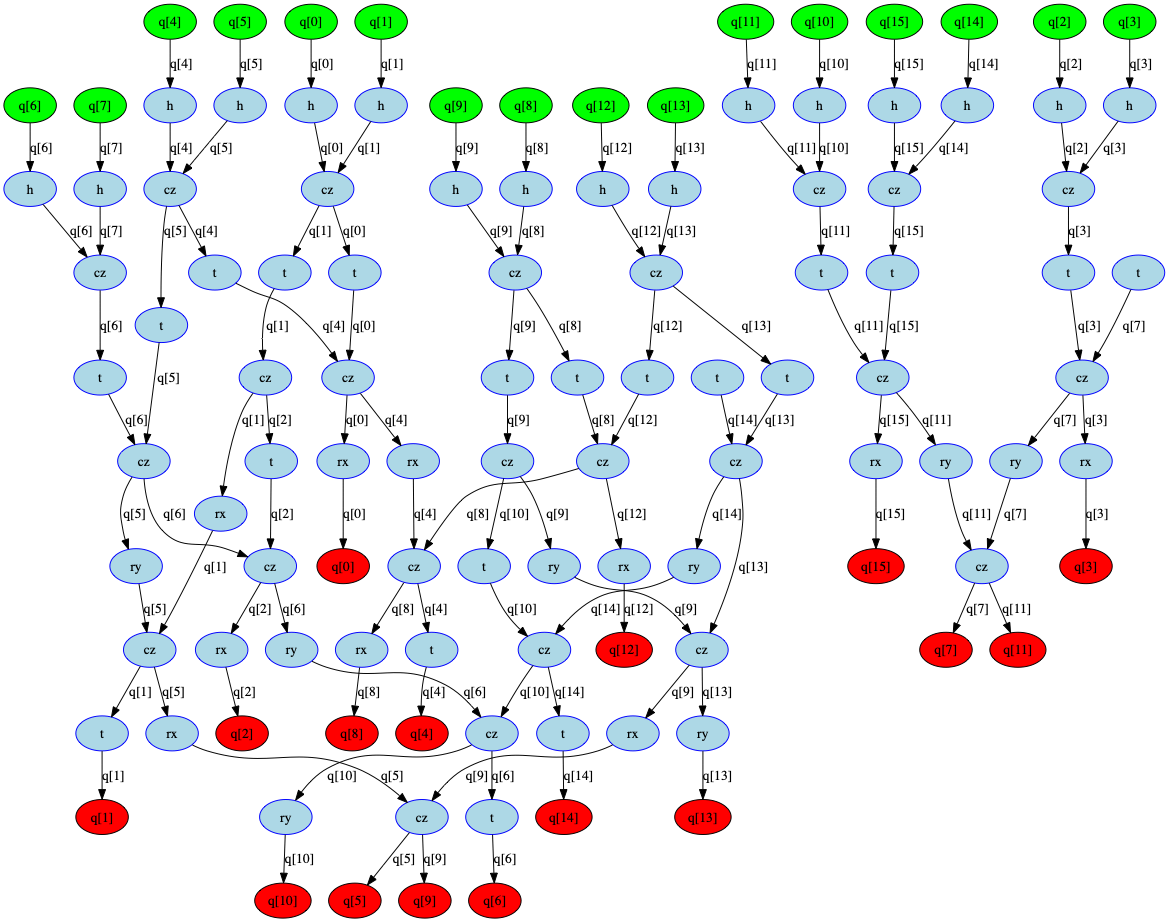

In [3]:
from qiskit.converters import circuit_to_dag, dag_to_circuit
from qiskit.tools.visualization import dag_drawer
from cutting_help_fun import *
import pickle
import networkx as nx

circ = pickle.load(open('results/supremacy_circuit_4_8.dump', 'rb' ))

original_dag = circuit_to_dag(circ)
q = circ.qregs[0]
positions = [(q[2], 1), (q[7], 1), (q[10], 1), (q[14], 1)]
wires_being_cut = [x[0] for x in positions]

cut_dag, path_order_dict = cut_edges(original_dag=original_dag, positions=positions)
in_out_arg_dict = contains_wire_nodes(cut_dag)
components = list(nx.weakly_connected_components(cut_dag._multi_graph))

sub_reg_dicts, input_wires_mapping = reg_dict_counter(cut_dag, wires_being_cut)
translation_dict = translation_dict_calc(input_wires_mapping, components, in_out_arg_dict, sub_reg_dicts)

# [print(x, path_order_dict[x]) for x in path_order_dict]
# print('\ntranslation_dict:', translation_dict)
# print('\ninput wires mapping:', input_wires_mapping)
# print('\nsub_reg_dicts:', sub_reg_dicts)

complete_path_map = complete_path_calc(path_order_dict, input_wires_mapping, translation_dict, sub_reg_dicts)
[print(x, complete_path_map[x]) for x in complete_path_map]
# sub_circs = generate_sub_circs(cut_dag, positions)
dag_drawer(cut_dag)

In [2]:
for i, sub_circ in enumerate(sub_circs):
    dag_drawer(circuit_to_dag(sub_circ), filename='results/sub_dag_%d.pdf' % i)
    sub_circ.draw(output='text',line_length = 400, filename='results/sub_circ_%d.txt' % i)
#     pickle.dump(sub_circ, open('results/sub_circ_%d.dump' % i, 'wb' ))

print('cut_dag has %d connected components' % nx.number_weakly_connected_components(cut_dag._multi_graph))

cut_dag has 2 connected components


In [6]:
for position in positions:
    print(position)

((QuantumRegister(16, 'q'), 2), 1)
((QuantumRegister(16, 'q'), 7), 1)
((QuantumRegister(16, 'q'), 10), 1)
((QuantumRegister(16, 'q'), 14), 1)
